In [45]:
import pandas as pd

student_info = pd.read_csv('data/student_info_cleaned.csv')

assessments = pd.read_csv('data/assessments.csv')
courses = pd.read_csv('data/courses.csv') # DONE
student_assessments = pd.read_csv('data/studentAssessment.csv')
 # IDK how to use???
# student_info = pd.read_csv('data/studentInfo.csv')
registration = pd.read_csv('data/studentRegistration.csv')
student_vle= pd.read_csv('data/studentVle.csv')
vle = pd.read_csv('data/vle.csv')

datasets = {
    'assessments':assessments,
    'courses':courses,
    'student_assessments':student_assessments,
    'student_info':student_info,
    'registration':registration,
    'student_vle':student_vle,
    'vle':vle}

student_df = student_info.merge(registration, how='inner', on=["code_module", "code_presentation", "id_student"])
student_df = student_df.drop(columns='date_unregistration')

svle = student_vle.groupby(['code_module', 'code_presentation', 'id_student']).agg({'sum_click': ['mean', 'sum'], 'date': 'nunique', 'id_site': 'nunique'}).reset_index()
svle.columns = ['code_module', 'code_presentation', 'id_student', 'mean_sum_click', 'total_sum_click', 'unique_date_count', 'unique_id_site_count']

svle = pd.merge(svle, courses, on=['code_module', 'code_presentation'], how='left')
svle['avg click/day'] =  svle['total_sum_click'] / svle['module_presentation_length']

svle = svle.rename(columns={'unique_date_count': 'days_logged', 'unique_id_site_count': 'material_interactions', 'module_presentation_length': 'module_length'})

vle_n = vle.groupby(['code_module', 'code_presentation'])['id_site'].nunique().reset_index()
svle = pd.merge(svle, vle_n, on=['code_module', 'code_presentation'], how='left')
svle['% material interaction'] =  100*svle['material_interactions'] / svle['id_site']

assessment_counts = assessments.groupby(['code_module', 'code_presentation'])['assessment_type'].value_counts().reset_index(name='count')
assessment_pivot = assessment_counts.pivot_table(index=['code_module', 'code_presentation'], columns='assessment_type', values='count', fill_value=0).reset_index()
assessment_pivot.columns.name = None  
assessment_pivot.columns = ['code_module', 'code_presentation', 'CMA', 'Exam', 'TMA']
svle = pd.merge(svle, assessment_pivot, on=['code_module', 'code_presentation'], how='left')

df_all = pd.merge(svle, student_df, on=['code_module', 'code_presentation', 'id_student'], how='inner')
columns_to_move = ['final_result', 'score', 'id_student']
df_all = df_all[columns_to_move + [col for col in df_all.columns if col not in columns_to_move]]

df_all.head()

,final_result,score,id_student,code_module,code_presentation,mean_sum_click,total_sum_click,days_logged,material_interactions,module_length,...,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,grade,studied_credits_binned,date_registration
0,Pass,82.4,11391,AAA,2013J,4.765306,934,40,55,268,...,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,A-,201+,-159.0
1,Pass,65.4,28400,AAA,2013J,3.337209,1435,80,84,268,...,Scotland,HE Qualification,20-30%,35-55,0,60,N,C,30-60,-53.0
2,Pass,76.3,31604,AAA,2013J,3.254902,2158,123,82,268,...,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,B,30-60,-52.0
3,Pass,55.0,32885,AAA,2013J,2.937500,1034,70,66,268,...,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,D,30-60,-176.0
4,Pass,66.9,38053,AAA,2013J,3.381743,2445,143,88,268,...,Wales,A Level or Equivalent,80-90%,35-55,0,60,N,C,30-60,-110.0


In [3]:
df_all.shape

(23684, 27)

In [46]:
#drop withdrawn students
df_all = df_all[df_all['final_result'] != 'Withdrawn']

In [47]:
import numpy as np
#order highest_education, imd_band, age_band, disability, studied_credits_binned, final_result
highest_education = {
    'No Formal quals': 0,
    'Lower Than A Level': 1,
    'A Level or Equivalent': 2,
    'HE Qualification': 3,
    'Post Graduate Qualification': 4
}

imd_band = {
    np.nan: -1,
    '0-10%': 0,
    '10-20': 1,
    '20-30%': 2,
    '30-40%': 3,
    '40-50%': 4,
    '50-60%': 5,
    '60-70%': 6,
    '70-80%': 7,
    '80-90%': 8,
    '90-100%': 9
}

age_band = {
    '0-35': 0,
    '35-55': 1,
    '55<=': 2
}

disability = {
    'N': 0,
    'Y': 1
}

studied_credits_binned = {
    '30-60': 0,
    '61-100': 1,
    '101-200': 2,
    '201+': 3
}

final_result = {
    'Fail': 0,
    'Pass': 1,
    'Distinction': 1,
    'Withdrawn': 0
}

data_dummies = pd.get_dummies(df_all, columns=['code_module', 'code_presentation', 'gender', 'region'])
data_dummies['highest_education'] = data_dummies['highest_education'].map(highest_education)
data_dummies['imd_band'] = data_dummies['imd_band'].map(imd_band)
data_dummies['age_band'] = data_dummies['age_band'].map(age_band)
data_dummies['disability'] = data_dummies['disability'].map(disability)
data_dummies['studied_credits_binned'] = data_dummies['studied_credits_binned'].map(studied_credits_binned)
data_dummies['final_result'] = data_dummies['final_result'].map(final_result)
data_dummies.shape

(19120, 48)

In [48]:
data_dummies = data_dummies[~((data_dummies['score'] > 50) & (data_dummies['final_result'] == 0))]
data_dummies = data_dummies[~((data_dummies['score'] < 50) & (data_dummies['final_result'] == 1))]

In [6]:
data_dummies.shape

(15359, 48)

model building

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE#pip install imbalanced-learn



X_dummy = data_dummies.drop(['final_result', 'studied_credits', 'id_student', 'score', 'grade'], axis=1)
X_dummy_combined = X_dummy.copy()
X_dummy_combined['score'] = data_dummies['score']
# X_dummy_combined.loc[(X_dummy_combined['score'] < 50) & (y_dummy['final_result'] == 1), 'score'] = 76
# X_dummy_combined.loc[y_dummy['final_result'] == 0, 'score'] = 35


y_dummy = data_dummies[['final_result']]

smote = SMOTE(sampling_strategy='minority', random_state=42)
X_dummy_smote, y_dummy_smote = smote.fit_resample(X_dummy_combined, y_dummy)

y_dummy_smote['score'] = X_dummy_smote['score']
y_dummy['score'] = X_dummy_combined['score']
X_dummy_smote = X_dummy_smote.drop(['score'], axis=1)

/var/folders/1z/_j8y7ndj06788g4f84n47dqm0000gn/T/ipykernel_95400/2502644455.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [30]:
print(y_dummy['final_result'].value_counts())

final_result
1    13788
0     1571
Name: count, dtype: int64


In [10]:
print(X_dummy_smote.shape)
print(y_dummy_smote.shape)
y_dummy_smote['final_result'].value_counts()

(27576, 43)
(27576, 2)


final_result
1    13788
0    13788
Name: count, dtype: int64

In [8]:
print(X_dummy_smote.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18934 entries, 0 to 18933
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   mean_sum_click               18934 non-null  float64
 1   total_sum_click              18934 non-null  float64
 2   days_logged                  18934 non-null  int64  
 3   material_interactions        18934 non-null  int64  
 4   module_length                18934 non-null  int64  
 5   avg click/day                18934 non-null  float64
 6   id_site                      18934 non-null  int64  
 7   % material interaction       18934 non-null  float64
 8   CMA                          18934 non-null  int64  
 9   Exam                         18934 non-null  int64  
 10  TMA                          18934 non-null  int64  
 11  highest_education            18934 non-null  int64  
 12  imd_band                     18934 non-null  int64  
 13  age_band        

In [11]:
# Concatenate the features and the target variable
data = pd.concat([X_dummy, y_dummy], axis=1)

# Compute the correlation matrix
corr_matrix = data.corr()

# Get the correlation of each variable with the 'final_result' variable
corr_with_target = corr_matrix['final_result']

corr_with_target = corr_with_target.sort_values(ascending=False)

# Print the result
print(corr_with_target)

final_result                   1.000000
score                          0.708328
% material interaction         0.280093
days_logged                    0.278491
material_interactions          0.205114
total_sum_click                0.203590
avg click/day                  0.202036
mean_sum_click                 0.110693
highest_education              0.094854
code_module_EEE                0.089711
code_module_BBB                0.071993
imd_band                       0.066058
module_length                  0.054956
code_module_FFF                0.053709
age_band                       0.049291
code_presentation_2013J        0.035106
code_module_AAA                0.034096
gender_F                       0.028532
region_Scotland                0.024944
region_South East Region       0.023507
region_South Region            0.019097
code_presentation_2014J        0.016927
region_North Region            0.016768
region_Ireland                 0.012980
region_East Midlands Region    0.011835


In [13]:
from sklearn.feature_selection import mutual_info_regression

# Compute the mutual information
mi = mutual_info_regression(X_dummy, y_dummy['final_result'])

# Create a Series with the results
mi_series = pd.Series(mi, index=X_dummy.columns)
mi_series = mi_series.sort_values(ascending=False)
mi_series_above_zero = mi_series[mi_series > 0].index.tolist()

# Print the result
print(mi_series)

% material interaction         0.084356
days_logged                    0.062633
avg click/day                  0.056097
total_sum_click                0.049623
material_interactions          0.038930
Exam                           0.016812
mean_sum_click                 0.015557
id_site                        0.015229
date_registration              0.008490
TMA                            0.008249
code_presentation_2014J        0.006502
region_London Region           0.005989
CMA                            0.005904
code_module_EEE                0.005630
module_length                  0.004763
num_of_prev_attempts           0.004628
code_module_CCC                0.004372
region_Yorkshire Region        0.004148
code_module_DDD                0.004120
age_band                       0.003938
code_module_FFF                0.003831
studied_credits_binned         0.003624
region_North Region            0.003498
code_presentation_2014B        0.003407
region_Wales                   0.002920


In [19]:
X_train_dummy, X_test_dummy, y_train_dummy, y_test_dummy = train_test_split(X_dummy_smote, y_dummy_smote, test_size=0.2, random_state=42, stratify=y_dummy_smote['final_result'])

In [23]:
X_train_pca, X_test_pca, y_train_dummy, y_test_dummy = train_test_split(X_pca, y_dummy_smote, test_size=0.2, random_state=42, stratify=y_dummy_smote['final_result'])

logistic regression

In [44]:
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter=20000)
logreg.fit(X_train_dummy, y_train_dummy['final_result'])

y_pred = logreg.predict(X_test_dummy)
acc = accuracy_score(y_test_dummy['final_result'], y_pred)
print('Accuracy Logistic Regression:', acc)

cm = confusion_matrix(y_test_dummy['final_result'], y_pred)

print("Confusion Matrix:")
print(cm)

Accuracy Logistic Regression: 0.9439811457577955
Confusion Matrix:
[[2519  239]
 [  70 2688]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



xgboost

In [ ]:
#XGBoost
from xgboost import XGBClassifier #pip install xgboost
from skopt import BayesSearchCV

# Define the parameter space
param_space = {
    'learning_rate': (0.01, 1.0, 'log-uniform'),
    'min_child_weight': (1, 10),
    'max_depth': (3, 50),
    'max_delta_step': (1, 20),
    'subsample': (0.01, 1.0, 'uniform'),
    'colsample_bytree': (0.01, 1.0, 'uniform'),
    'colsample_bylevel': (0.01, 1.0, 'uniform'),
    'reg_lambda': (1e-9, 1000, 'log-uniform'),
    'reg_alpha': (1e-9, 1.0, 'log-uniform'),
    'gamma': (1e-9, 0.5, 'log-uniform'),
    'n_estimators': (50, 200),
    'scale_pos_weight': (1e-6, 500, 'log-uniform')
}

# Create a BayesSearchCV object
opt_xgb = BayesSearchCV(
    estimator=XGBClassifier(n_jobs=-1),
    search_spaces=param_space,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    n_iter=150,
    verbose=1,
    refit=True,
)

# Run the optimization
opt_xgb.fit(X_train_dummy, y_train_dummy)

In [16]:
from xgboost import XGBClassifier #pip install xgboost
xgb = XGBClassifier()
xgb.fit(X_train_dummy, y_train_dummy['final_result'])

y_pred = xgb.predict(X_test_dummy)
acc = accuracy_score(y_test_dummy['final_result'], y_pred)
print("Accuracy XGBoost:", acc)

cm = confusion_matrix(y_test_dummy['final_result'], y_pred)
print("Confusion Matrix:")
print(cm)

Accuracy XGBoost: 0.9384737259044098
Confusion Matrix:
[[1738  156]
 [  77 1816]]


In [16]:
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix

cb = CatBoostClassifier()
cb.fit(X_train_dummy, y_train_dummy['final_result'])

y_pred = cb.predict(X_test_dummy)
acc = accuracy_score(y_test_dummy['final_result'], y_pred)
print('Accuracy CatBoost:', acc)
cm = confusion_matrix(y_test_dummy['final_result'], y_pred)
print("Confusion Matrix:")
print(cm)

Learning rate set to 0.038606
0:	learn: 0.6647269	total: 13.2ms	remaining: 13.2s
1:	learn: 0.6280049	total: 20.7ms	remaining: 10.3s
2:	learn: 0.6032085	total: 26.2ms	remaining: 8.72s
3:	learn: 0.5804459	total: 30.6ms	remaining: 7.63s
4:	learn: 0.5546039	total: 35.2ms	remaining: 7s
5:	learn: 0.5360748	total: 40.4ms	remaining: 6.69s
6:	learn: 0.5147305	total: 45.2ms	remaining: 6.42s
7:	learn: 0.4968609	total: 49.5ms	remaining: 6.14s
8:	learn: 0.4837403	total: 54ms	remaining: 5.95s
9:	learn: 0.4724020	total: 58.2ms	remaining: 5.76s
10:	learn: 0.4577563	total: 62.3ms	remaining: 5.6s
11:	learn: 0.4475671	total: 67.5ms	remaining: 5.56s
12:	learn: 0.4408909	total: 71.7ms	remaining: 5.44s
13:	learn: 0.4304970	total: 76.9ms	remaining: 5.42s
14:	learn: 0.4229562	total: 80.9ms	remaining: 5.31s
15:	learn: 0.4122917	total: 85.9ms	remaining: 5.28s
16:	learn: 0.4065334	total: 90ms	remaining: 5.21s
17:	learn: 0.3999179	total: 94.2ms	remaining: 5.14s
18:	learn: 0.3942399	total: 98.3ms	remaining: 5.07s


catboost

In [35]:
from catboost import CatBoostClassifier
from skopt import BayesSearchCV

counter = [0]

def on_step(optim_result):
    # Increment the counter
    counter[0] += 1
    print(f"Completed iteration {counter[0]}")
    
cb = CatBoostClassifier(verbose=False)

# Define search spaces
param_space = {
    'iterations': (50, 1000),
    'depth': (1, 16),
    'learning_rate': (0.01, 1.0, 'log-uniform'),
    'random_strength': (1e-9, 10, 'log-uniform'),
    'bagging_temperature': (0.0, 1.0),
    'border_count': (1, 255),
    'l2_leaf_reg': (2, 30),
    'scale_pos_weight':(0.01, 1.0, 'uniform')
}

# Initialize BayesSearchCV
opt_cb = BayesSearchCV(
    estimator=cb,
    search_spaces=param_space,
    scoring='accuracy',
    n_iter=150,
    n_jobs=-1,
    return_train_score=False,
    refit=True,
    optimizer_kwargs={'base_estimator': 'GP'},
    random_state=42
)

# Fit the model
opt_cb.fit(X_train_dummy, y_train_dummy['final_result'], callback=on_step)

# Print best parameters and score
print(f'Best parameters: {opt_cb.best_params_}')
print(f'Best score: {opt_cb.best_score_}')

ERROR! Session/line number was not unique in database. History logging moved to new session 100
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 42
Completed iterat

In [50]:
from collections import OrderedDict
from catboost import CatBoostClassifier #pip install catboost

params = OrderedDict([('bagging_temperature', 1.0), ('border_count', 148), ('depth', 13), ('iterations', 976), ('l2_leaf_reg', 30), ('learning_rate', 0.02389354323083735), ('random_strength', 1e-09), ('scale_pos_weight', 0.9510644977326121)])
params['iterations'] = 1000

params2 = OrderedDict([('bagging_temperature', 1.0), ('border_count', 86), ('depth', 16), ('iterations', 868), ('l2_leaf_reg', 2), ('learning_rate', 0.06598200301644333), ('random_strength', 10.0), ('scale_pos_weight', 0.8384915263866678)])
params2['iterations'] = 1000
cb = CatBoostClassifier(**params2)
cb.fit(X_train_dummy, y_train_dummy['final_result'])

y_pred = cb.predict(X_test_dummy)
acc = accuracy_score(y_test_dummy['final_result'], y_pred)
print('Accuracy CatBoost:', acc)
cm = confusion_matrix(y_test_dummy['final_result'], y_pred)
print("Confusion Matrix:")
print(cm)

0:	learn: 0.6198528	total: 2.95s	remaining: 49m 3s
1:	learn: 0.5658979	total: 4.84s	remaining: 40m 16s
2:	learn: 0.5310979	total: 4.91s	remaining: 27m 11s
3:	learn: 0.4920655	total: 6.76s	remaining: 28m 2s
4:	learn: 0.4590550	total: 8.65s	remaining: 28m 41s
5:	learn: 0.4320212	total: 10.5s	remaining: 28m 52s
6:	learn: 0.4027444	total: 12.2s	remaining: 28m 52s
7:	learn: 0.3992206	total: 12.2s	remaining: 25m 15s
8:	learn: 0.3811747	total: 14.7s	remaining: 26m 53s
9:	learn: 0.3666077	total: 17.7s	remaining: 29m 9s
10:	learn: 0.3483203	total: 19.7s	remaining: 29m 29s
11:	learn: 0.3355512	total: 22.7s	remaining: 31m 11s
12:	learn: 0.3222862	total: 25.4s	remaining: 32m 10s
13:	learn: 0.3098346	total: 28.1s	remaining: 33m 1s
14:	learn: 0.2951219	total: 30.8s	remaining: 33m 41s
15:	learn: 0.2887105	total: 32.2s	remaining: 32m 59s
16:	learn: 0.2778510	total: 34.4s	remaining: 33m 10s
17:	learn: 0.2691599	total: 36.3s	remaining: 33m
18:	learn: 0.2628512	total: 38s	remaining: 32m 44s
19:	learn: 0.

In [71]:
# Get feature importance
feature_importances = cb.get_feature_importance()

# Get feature names
feature_names = X_train_dummy.columns

# Create a DataFrame for easier visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)
# print(importance_df)

importance_df['Importance'] /= importance_df['Importance'].sum()
importance_df.reset_index(drop=True, inplace=True)

# Get the top 10 features
top_10_features = importance_df.head(10)

print(top_10_features.to_string())

                  Feature  Importance
0       highest_education    0.061120
1           module_length    0.060531
2       date_registration    0.059365
3                gender_F    0.058858
4                imd_band    0.056869
5                gender_M    0.055753
6             days_logged    0.052925
7  % material interaction    0.040333
8  studied_credits_binned    0.038496
9          mean_sum_click    0.035681


In [61]:
cb_plain = CatBoostClassifier(verbose=False)
cb_plain.fit(X_train_dummy, y_train_dummy['final_result'])

y_pred = cb_plain.predict(X_test_dummy)
acc = accuracy_score(y_test_dummy['final_result'], y_pred)
print('Accuracy CatBoost:', acc)
cm = confusion_matrix(y_test_dummy['final_result'], y_pred)
print("Confusion Matrix:")
print(cm)

Accuracy CatBoost: 0.9501450326323423
Confusion Matrix:
[[2556  202]
 [  73 2685]]


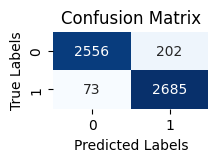

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred = cb_plain.predict(X_test_dummy)
cm = confusion_matrix(y_test_dummy['final_result'], y_pred)
plt.figure(figsize=(2,1))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title("Confusion Matrix")
plt.show()

In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(y_test_dummy['final_result'], y_pred)
print('Precision:', precision)

# Recall
recall = recall_score(y_test_dummy['final_result'], y_pred)
print('Recall:', recall)

# F1 Score
f1 = f1_score(y_test_dummy['final_result'], y_pred)
print('F1 Score:', f1)

Precision: 0.9491586108127461
Recall: 0.9612037708484409
F1 Score: 0.9551432174382994


random forest

In [20]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train_dummy, y_train_dummy['final_result'])

y_pred = rf.predict(X_test_dummy)
acc = accuracy_score(y_test_dummy['final_result'], y_pred)
print('Accuracy Random Forest:', acc)

Accuracy Random Forest: 0.9390018484288355


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
categories = ['code_module', 'code_presentation', 'gender', 'region']
numerical_features = [col for col in X_train_ord.columns if col not in categories]

X_train_dummy = scaler.fit_transform(X_train_dummy)
X_test_dummy = scaler.fit_transform(X_test_dummy)

In [40]:
y_train_dummy.head()

,final_result,score
19901,0,77.718532
14299,1,84.191919
25453,0,84.567035
6573,1,85.348315
11571,0,67.857143


In [35]:
from tensorflow.keras.layers import Dropout, Input, Dense, BatchNormalization
from tensorflow.keras.regularizers import l2
import tensorflow as tf

X_train_dummy_np = X_train_dummy.astype('float32')
y_train_dummy_np = y_train_dummy.drop(columns=['final_result']).astype('float32')

input_layer = Input(shape=(X_train_dummy.shape[1],))

dense = Dense(128, kernel_initializer=tf.keras.initializers.HeNormal(), kernel_regularizer=l2(0.01))(input_layer)
dense = BatchNormalization()(dense)
dense = tf.keras.activations.relu(dense)
dense = Dropout(0.2)(dense)

dense = Dense(128, kernel_initializer=tf.keras.initializers.HeNormal(), kernel_regularizer=l2(0.01))(dense)
dense = BatchNormalization()(dense)
dense = tf.keras.activations.relu(dense)
dense = Dropout(0.2)(dense)

dense = Dense(128, kernel_initializer=tf.keras.initializers.HeNormal(), kernel_regularizer=l2(0.01))(dense)
dense = BatchNormalization()(dense)
dense = tf.keras.activations.relu(dense)
dense = Dropout(0.2)(dense)

output = Dense(1, activation='linear')(dense)

model = tf.keras.models.Model(inputs=input_layer, outputs=output)
model2 = tf.keras.models.Model(inputs=input_layer, outputs=output)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='model.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)
checkpoint2 = tf.keras.callbacks.ModelCheckpoint(
    filepath='model2.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model2.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
hist = model.fit(X_train_dummy_np, y_train_dummy_np, epochs=15, batch_size=32, validation_split=0.2, callbacks=[checkpoint])

#misclassified from the first
print("predicting")
preds1 = model.predict(X_train_dummy_np)
precisions, recalls, thresholds = precision_recall_curve(y_train_dummy['final_result'], preds1)
best_threshold = thresholds[np.argmax(precisions + recalls)]
print("misclassifying")

predictions_classified = [1 if y >= best_threshold else 0 for y in preds1.flatten()]
# y_train_dummy_binary = [1 if y >= 50 else 0 for y in y_train_dummy['score']]
np.random.seed(0)
misclassified = np.array(predictions_classified) != np.array(y_train_dummy['final_result'])
misclassified_indices = np.where(misclassified)[0]
correct_indices = np.where(~misclassified)[0]
random_correct_indices = np.random.choice (correct_indices, size=int(len(misclassified_indices)*2), replace=False)
training_indices = np.concatenate([misclassified_indices, random_correct_indices])
X_train2 = X_train_dummy_np.iloc[training_indices]
y_train2 = y_train_dummy_np.iloc[training_indices]

model2.fit(X_train2, y_train2, epochs=30, batch_size=32, validation_split=0.2, callbacks=[checkpoint2])

Epoch 1/15
552/552 [==============================] - ETA: 0s - loss: 1537.8672 - accuracy: 5.6664e-05
Epoch 1: val_loss improved from inf to 852.74023, saving model to model.h5
552/552 [==============================] - 21s 34ms/step - loss: 1537.8672 - accuracy: 5.6664e-05 - val_loss: 852.7402 - val_accuracy: 0.0000e+00
Epoch 2/15
  1/552 [..............................] - ETA: 37s - loss: 228.1072 - accuracy: 0.0000e+00

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



552/552 [==============================] - ETA: 0s - loss: 282.1672 - accuracy: 0.0000e+00
Epoch 2: val_loss improved from 852.74023 to 546.18390, saving model to model.h5
552/552 [==============================] - 19s 34ms/step - loss: 282.1672 - accuracy: 0.0000e+00 - val_loss: 546.1839 - val_accuracy: 0.0000e+00
Epoch 3/15
552/552 [==============================] - ETA: 0s - loss: 247.5201 - accuracy: 0.0000e+00
Epoch 3: val_loss improved from 546.18390 to 252.40540, saving model to model.h5
552/552 [==============================] - 18s 33ms/step - loss: 247.5201 - accuracy: 0.0000e+00 - val_loss: 252.4054 - val_accuracy: 0.0000e+00
Epoch 4/15
552/552 [==============================] - ETA: 0s - loss: 228.3687 - accuracy: 0.0000e+00
Epoch 4: val_loss improved from 252.40540 to 227.16821, saving model to model.h5
552/552 [==============================] - 18s 33ms/step - loss: 228.3687 - accuracy: 0.0000e+00 - val_loss: 227.1682 - val_accuracy: 0.0000e+00
Epoch 5/15
552/552 [=======

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



195/195 [==============================] - ETA: 0s - loss: 215.1295 - accuracy: 0.0000e+00
Epoch 2: val_loss improved from 297.63657 to 267.74973, saving model to model2.h5
195/195 [==============================] - 6s 32ms/step - loss: 215.1295 - accuracy: 0.0000e+00 - val_loss: 267.7497 - val_accuracy: 0.0000e+00
Epoch 3/30
195/195 [==============================] - ETA: 0s - loss: 215.3079 - accuracy: 0.0000e+00
Epoch 3: val_loss did not improve from 267.74973
195/195 [==============================] - 8s 40ms/step - loss: 215.3079 - accuracy: 0.0000e+00 - val_loss: 525.0049 - val_accuracy: 0.0000e+00
Epoch 4/30
195/195 [==============================] - ETA: 0s - loss: 218.8660 - accuracy: 0.0000e+00
Epoch 4: val_loss did not improve from 267.74973
195/195 [==============================] - 6s 32ms/step - loss: 218.8660 - accuracy: 0.0000e+00 - val_loss: 649.2940 - val_accuracy: 0.0000e+00
Epoch 5/30
193/195 [============================>.] - ETA: 0s - loss: 210.4950 - accuracy: 0.

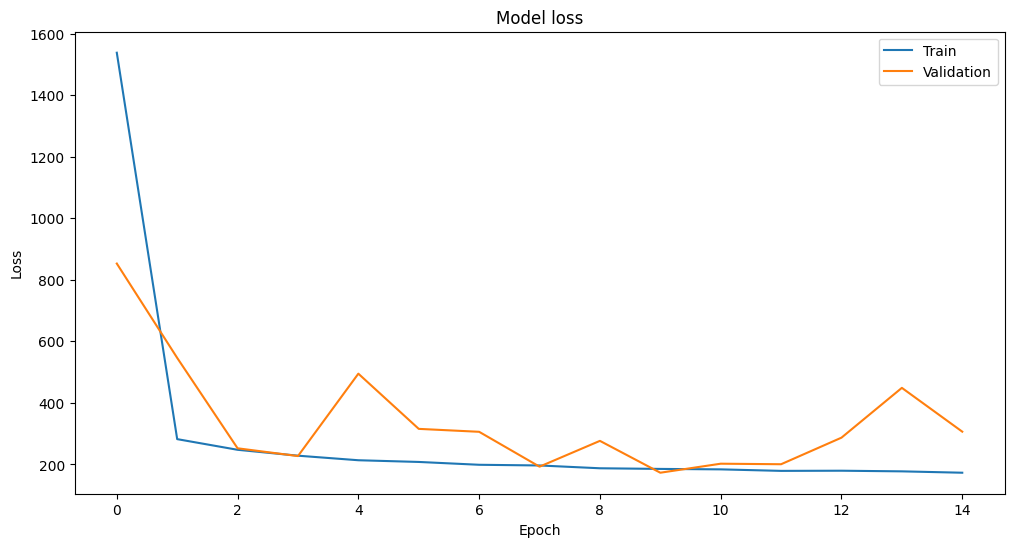

In [36]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [42]:
from sklearn.metrics import confusion_matrix, precision_recall_curve
from tensorflow.keras.models import load_model

best_model1 = load_model('model.h5')
best_model2 = load_model('model2.h5')

X_test_dummy_np = X_test_dummy.astype('float32')

preds1 = best_model1.predict(X_test_dummy_np)
precisions, recalls, thresholds = precision_recall_curve(y_test_dummy['final_result'], preds1)
best_threshold = thresholds[np.argmax(precisions + recalls)]

print('best threshold', best_threshold)

predictions_classified1 = []
for i, pred in enumerate(preds1):
#     print(i, pred)
    if (pred >= best_threshold):
        predictions_classified1.append(1)
    else:
        predictions_classified1.append(0)
print(len(predictions_classified1))

acc = accuracy_score(y_test_dummy['final_result'], predictions_classified1)
print("acc1", acc)
cm = confusion_matrix(y_test_dummy['final_result'], predictions_classified1)

print("Confusion Matrix1:")
print(cm)
positive_preds = np.array(predictions_classified1) == 1

preds2 = best_model2.predict(X_test_dummy_np)

best_ratio = 0
best_score = 0

for i in range(0, 101):
    ratio = i/100
    average_preds = (preds1 * ratio) + (preds2 * (1 - ratio))
    precisions, recalls, thresholds = precision_recall_curve(y_test_dummy['final_result'], average_preds)
    best_threshold = thresholds[np.argmax(precisions + recalls)]
    final_preds_classified = [1 if y >= best_threshold else 0 for y in average_preds.flatten()]
    acc = accuracy_score(y_test_dummy['final_result'], final_preds_classified)
    if acc > best_score:
        best_score = acc
        best_ratio = ratio

print("Best ratio", best_ratio, "Best score", best_score)

average_preds = (preds1 * best_ratio) + (preds2 * (1 - best_ratio))
precisions, recalls, thresholds = precision_recall_curve(y_test_dummy['final_result'], average_preds)
best_threshold = thresholds[np.argmax(precisions + recalls)]
final_preds_classified = [1 if y >= best_threshold else 0 for y in average_preds.flatten()]

acc = accuracy_score(y_test_dummy['final_result'], final_preds_classified)
print("Accuracy", acc)

cm = confusion_matrix(y_test_dummy['final_result'], final_preds_classified)
print("Confusion Matrix:")
print(cm)


173/173 [==============================] - 1s 4ms/step
best threshold 55.03595
5516
acc1 0.898658448150834
Confusion Matrix1:
[[2320  438]
 [ 121 2637]]
173/173 [==============================] - 1s 4ms/step
Best ratio 0.1 Best score 0.9254894851341552
Accuracy 0.9254894851341552
Confusion Matrix:
[[2443  315]
 [  96 2662]]


In [43]:
preds1_train = best_model1.predict(X_train_dummy_np)
preds2_train = best_model2.predict(X_train_dummy_np)

average_preds_train = (preds1_train * best_ratio) + (preds2_train * (1 - best_ratio))
precisions, recalls, thresholds = precision_recall_curve(y_train_dummy['final_result'], average_preds_train)
best_threshold = thresholds[np.argmax(precisions + recalls)]
final_preds_classified_train = [1 if y >= best_threshold else 0 for y in average_preds_train.flatten()]

acc = accuracy_score(y_train_dummy['final_result'], final_preds_classified_train)
print("Accuracy", acc)

cm = confusion_matrix(y_train_dummy['final_result'], final_preds_classified_train)
print("Confusion Matrix:")
print(cm)

690/690 [==============================] - 3s 4ms/step
Accuracy 0.9252946509519492
Confusion Matrix:
[[ 9694  1336]
 [  312 10718]]


In [ ]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [ ]:
#DO NOT RUN, TAKES FOREVER, OPTIMAL PARAMS PRINTED BELOW

from skopt import BayesSearchCV #pip install scikit-optimize

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from joblib import parallel_backend

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

def create_model(neurons, dropout_rate, num_layers, learning_rate):
    input_layer = Input(shape=(X_train_dummy.shape[1],))

    dense = Dense(neurons, kernel_initializer=tf.keras.initializers.HeNormal())(input_layer)
    dense = BatchNormalization()(dense)
    dense = tf.keras.activations.relu(dense)
    dense = Dropout(dropout_rate)(dense)
    
    for i in range(num_layers - 1):
        dense = Dense(neurons, kernel_initializer=tf.keras.initializers.HeNormal())(dense)
        dense = BatchNormalization()(dense)
        dense = tf.keras.activations.relu(dense)
        dense = Dropout(dropout_rate)(dense)

    output = Dense(1, activation='sigmoid')(dense)
    
    model = tf.keras.models.Model(inputs=input_layer, outputs=output)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

wrapped_create_model = KerasClassifier(build_fn=create_model, verbose=1, epochs=25)

param_space = {
    'neurons': (8, 512),
    'dropout_rate': (0.1, 0.5),
    'num_layers': (1, 5),
    'learning_rate': (0.0001, 0.1)
}

opt = BayesSearchCV(
    wrapped_create_model,
    param_space,
    n_iter=50,
    cv=3,
    n_jobs=1,
    verbose=1
)

opt.fit(X_train_dummy, y_train_dummy)


In [ ]:
best_params = opt.best_params_
print(best_params)

In [ ]:
optimal_parameters = opt.best_params_

optimal_model = create_model(
    neurons=optimal_parameters['neurons'],
    dropout_rate=optimal_parameters['dropout_rate'],
    num_layers=optimal_parameters['num_layers'],
    learning_rate=optimal_parameters['learning_rate']
)

history = optimal_model.fit(X_train_dummy, y_train_dummy, epochs=30, batch_size=32, validation_split=0.2)

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
score = optimal_model.evaluate(X_test_dummy, y_test_dummy)
print("Accuracy (tuned model):", score[1])